In [34]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
import os
from sklearn.model_selection import train_test_split
from scipy.stats import entropy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import pickle
from datetime import datetime


# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 
import torch # For building the networks 
import torchtuples as tt # Some useful functions
from pycox.datasets import metabric
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

np.random.seed(1234)
_ = torch.manual_seed(123)
random_state = 43
cancers = ['BLCA', 'BRCA', 'HNSC', 'LAML', 'LGG', 'LUAD']
path_prefix = 'C:/Users/sharony/SurvivalAnalysis/'
if os.getlogin() =='meiry':
    path_prefix = 'D:/sharon/medical_genomics_data/'

train_portion = 0.65
val_portion = 0.20
# test portion is the remainder to 1

In [39]:
X, y = load_gbsg2()


In [47]:
len(y)

686

In [50]:
y.dtype

dtype([('cens', '?'), ('time', '<f8')])

In [45]:
type(y[0])

numpy.void

In [9]:
def calc_time_to_event(x):
    #print(type(x) , x)
    assert x.vital_status in ['Dead', 'Alive']
    if x.vital_status=='Dead':
        try:
            assert isinstance(int(x.death_days_to), int)
        except:
            print(type(x.death_days_to), 'non int entry in x.death_days_to' , x.death_days_to, 'removing row',x.vital_status, x.death_days_to)        
            return None
        assert float(x.death_days_to) >= 0
        return int(x.death_days_to)
    try:
        assert isinstance(int(x.last_contact_days_to), int) 
    except :
        print(type(x.last_contact_days_to), 'non int entry in x.last_contact_days_to' , x.last_contact_days_to, 'removing row',x.vital_status, x.death_days_to)        
        return None
    if int(x.last_contact_days_to) < 0:
        print('negative entry in x.last_contact_days_to' , x.last_contact_days_to, 'fixing it')
    return abs(int(x.last_contact_days_to))


In [62]:
num_durations = 50

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['time_to_event'].values, df['event'].values)

def sksurv_model(ct, clinical_data, omics, comment):

    data = omics.copy()
    T = list(clinical_data.apply(calc_time_to_event, axis = 1).astype('int32').values)
    E = list((clinical_data['vital_status'].values == 'Dead').astype(bool))
    y = np.array([(E[i], T[i]) for i, _ in enumerate(T)], dtype=([('cens', '?'), ('time', '<f8')]))
    X_train, X_test, y_train, y_test = train_test_split(omics, y, test_size=0.20, random_state=random_state)
    rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)
    rsf.fit(X_train, y_train)
    ci = rsf.score(X_test, y_test)
    print(datetime.now(), ct, comment, ci)
    surv = rsf.predict_survival_function(X_test, return_array=True)

    for i, s in enumerate(surv[0:5]):
        plt.step(rsf.event_times_, s, where="post", label=str(i))
        plt.ylabel("Survival probability")
        plt.xlabel("Time in days")
        plt.legend()
        plt.grid(True)
    for i, s in enumerate(surv[0:5]):
        plt.step(rsf.event_times_, s, where="post", label=str(i))
        plt.ylabel("Cumulative hazard")
        plt.xlabel("Time in days")
        plt.legend()
        plt.grid(True)
    return ci

2020-12-12 19:21:29.550094 BLCA Entered
negative entry in x.last_contact_days_to -21 fixing it
negative entry in x.last_contact_days_to -64 fixing it
2020-12-12 19:25:08.864238 BLCA merged 0.5960264900662252
2020-12-12 19:25:09.261173 BLCA merged 0.5960264900662252
negative entry in x.last_contact_days_to -21 fixing it
negative entry in x.last_contact_days_to -64 fixing it
2020-12-12 19:27:47.107248 BLCA exp 0.6059602649006622
2020-12-12 19:27:47.438357 BLCA exp 0.6059602649006622
negative entry in x.last_contact_days_to -21 fixing it
negative entry in x.last_contact_days_to -64 fixing it
2020-12-12 19:30:41.439089 BLCA methy 0.6655629139072847
2020-12-12 19:30:41.759229 BLCA methy 0.6655629139072847
negative entry in x.last_contact_days_to -21 fixing it
negative entry in x.last_contact_days_to -64 fixing it
2020-12-12 19:31:04.420378 BLCA mirna 0.5860927152317881
2020-12-12 19:31:04.762460 BLCA mirna 0.5860927152317881

2020-12-12 19:31:04.763456 BLCA DONE

2020-12-12 19:31:04.763456 

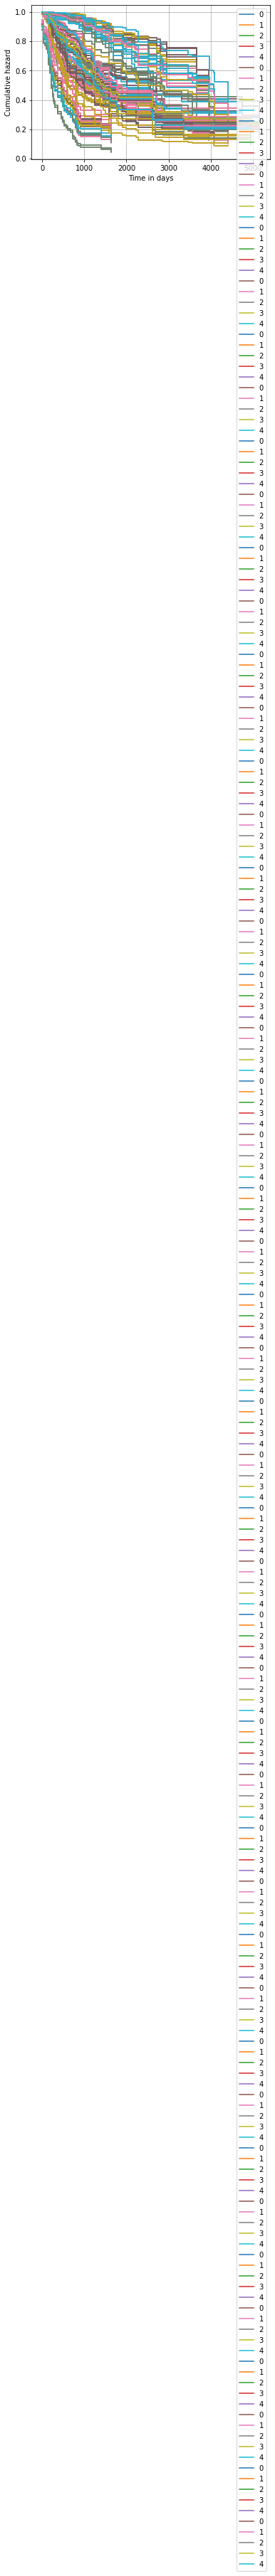

In [63]:
#model_func = nn_model
model_func = sksurv_model
for ct in cancers:
    print(datetime.now(), ct, 'Entered')
    ct_path = f'{path_prefix}{ct}'
    if not os.path.exists(f'{ct}_clinical.pkl'):
        print(datetime.now(), ct, 'skipping because clinical data was not processed')
        continue
    clinical_data = pickle.load(open(f'{ct}_clinical.pkl', 'rb'))
    if not os.path.exists(f'{ct}_omics.pkl'):
        print(datetime.now(), 'Not found', 'merged', f'{ct}_omics.pkl')
    else:
        omics = pickle.load(open(f'{ct}_omics.pkl', 'rb'))
        ci = model_func(ct, clinical_data, omics, 'merged')
        print(datetime.now(), ct, 'merged', ci)
    if not os.path.exists(f'{ct}_exp_omics.pkl'):
        print(datetime.now(), 'Not found', 'exp', f'{ct}_omics.pkl')
    else:
        exp = pickle.load(open(f'{ct}_exp_omics.pkl', 'rb'))
        ci = model_func(ct, clinical_data, exp, 'exp')
        print(datetime.now(), ct, 'exp',  ci)
    if not os.path.exists(f'{ct}_methy_omics.pkl'):
        print(datetime.now(), 'Not found', 'methy', f'{ct}_methy_omics.pkl')
    else:
        methy = pickle.load(open(f'{ct}_methy_omics.pkl', 'rb'))
        ci = model_func(ct, clinical_data, methy, 'methy')
        print(datetime.now(), ct, 'methy',  ci)
    if not os.path.exists(f'{ct}_mirna_omics.pkl'):
        print(datetime.now(), 'Not found', 'mirna', f'{ct}_mirna_omics.pkl')
    else:
        mirna = pickle.load(open(f'{ct}_mirna_omics.pkl', 'rb'))
        ci = model_func(ct, clinical_data, mirna, 'mirna')
        print(datetime.now(), ct, 'mirna',  ci)
    print()
    print(datetime.now(), ct, 'DONE')
    print()
